# Case study

## The Simulation script runs a specific case of simulation step by step.

In [1]:
from SimulationScript import *
import matplotlib.pyplot as plt

In [2]:
# Qutip and MKL are not working well
# https://github.com/qutip/qutip/issues/975
import qutip.settings as qset
qset.has_mkl = False

We will simulate the steady state of a system composed by two coupled harmonic simulators. This is the Hamiltonian with the drive on cavity A and B:

$$\mathcal{H}=\left(\omega_a - \omega_d^a\right)\hat{a}^\dagger\hat{a}+\left(\omega_b - \omega_d^b\right)\hat{b}^\dagger\hat{b} + g\left(\hat{a}^\dagger+\hat{a}\right)\left(\hat{b}^\dagger+\hat{b}\right)+A_a\left(\hat{a}^\dagger+\hat{a}\right)+A_b\left(\hat{b}^\dagger+\hat{b}\right)$$

In [3]:
def our_hamiltonian(wa,wd_a,Aa,a,wb,wd_b,Ab,b,g):
    return (wa-wd_a)*a.dag()*a\
           + (wb-wd_b)*b.dag()*b \
           + g*(a.dag()+a)*(b.dag()+b)\
           + Aa*(a.dag()+a)\
           + Ab*(b.dag()+b)

The next step is to define the function that will do our simulation. It must receive three parameters: a sweep, a shared list, a string. The sweep is a list of dictionary, the shared list is used to save the data and the string is folder name to save the backup data (must be optional).

In [4]:
def our_execute(task):
    print(task['name']+'id'+str(task['idx']))
    rho = steadystate(task["H"],task["c_ops"])
        
    result = {}

    result["task"] = task
    result["rho"] = rho
        
    return result

You may have noticed the different values stored in task. H is the Hamiltonian, c_ops is a list of collapse operators, name is the name of this sweep (we will sweep the value of drive wd_a to different values of g, then the name should be something like "g0" or "g2"), idx is an indice of the order of the task on sweep (this is important because we cannot control the order of parallel processing methods). Here is an function that create a task

In [46]:
utilities.n_thermal(5.1*1e9,10e-3*sc.k/sc.h)

2.3450066686778643e-11

In [11]:
def our_create_task(a,b,wa,wd_a,Aa,ka,wb,wd_b,Ab,kb,g,T,N,name,idx,initial_parameter, final_parameter,n_points):
    
    n_th_a = utilities.n_thermal(wa*1e9,T*sc.k/sc.h)
    n_th_b = utilities.n_thermal(wb*1e9,T*sc.k/sc.h)

    rate_relaxation_a = ka*(1+n_th_a)
    rate_relaxation_b = kb*(1+n_th_b)

    rate_excitation_a = ka*(n_th_a)
    rate_excitation_b = kb*(n_th_b)
    
    c_ops = []

    if rate_excitation_a > 0.0:
        c_ops.append(np.sqrt(rate_excitation_a)*a.dag())

    if rate_relaxation_a > 0.0:
        c_ops.append(np.sqrt(rate_relaxation_a)*a)
        
    if rate_excitation_b > 0.0:
        c_ops.append(np.sqrt(rate_excitation_b)*b.dag())

    if rate_relaxation_b > 0.0:
        c_ops.append(np.sqrt(rate_relaxation_b)*b)
    
    H = our_hamiltonian(wa,wd_a,Aa,a,wb,wd_b,Ab,b,g)
    
    task = {}
    
    task["n_points"] = n_points;
    task["initial_parameter"] = initial_parameter;
    task["final_parameter"] = final_parameter;
    task["idx"] = idx;
    task["name"] = name;
    
    task["H"] = H
    task["N"] = N
    task["T"] = T

    task["a"] = a
    task["wa"] = wa
    task["wd_a"] = wd_a
    task["ka"] = ka
    task["Aa"] = Aa

    task["b"] = b
    task["wb"] = wb
    task["wd_b"] = wd_b
    task["kb"] = kb
    task["Ab"] = Ab
    
    task["g"] = g
    
    task["c_ops"] = c_ops
    
    return task
    
    

We store way more data than needed because it could be useful later in the analysis

An sweep is a list of tasks where one parameter is varied in each task. Here is an example of sweep on the oscillator a drive frequency.

In [12]:
def our_create_sweep_wd_a(a,b,wa,Aa,ka,wb,wd_b,Ab,kb,g,T,N,name,initial_wd_a, final_wd_a, n_points):
    wd_as = np.linspace(initial_wd_a,final_wd_a,n_points)
    sweep = []
    for (idx,wd_a) in enumerate(wd_as):
        task = our_create_task(a,b,wa,wd_a,Aa,ka,wb,wd_b,Ab,kb,g,T,N,name,idx,initial_wd_a, final_wd_a,n_points)
        sweep.append(task)
    return sweep

The final step is to create an Experiment Class. Its instance will connect our simulation settings to the simulation function which delegates the multiples sweeps to different processes. The class must have the method process, and its parameters must be: self and list. The list is the same shared list passed to our_execute.

In [13]:
class OurExperiment:
    
    def __init__(self,
                 a,
                 b,
                 name="",
                 sweeps=[],
                 sweep_name="",
                 number_of_sweeps=0,
                 n_points=0,
                 fock=0):
        
        self.a = a
        self.b = b
        self.name = name
        self.sweeps = np.array(sweeps)
        self.n_points = n_points
        self.fock = fock
        self.expect_a = {}
        self.sweep_variable = {}
        self.tasks = {}
        self.number_of_sweeps = number_of_sweeps
        self.sweep_name = sweep_name
        
        self.sweep_variable[self.sweep_name] = np.zeros(self.n_points,dtype=float)
        
        for i in range(0,self.number_of_sweeps):
            self.tasks[self.sweep_name+str(i)] = np.zeros(self.n_points,dtype=dict)
    
    def process(self,l):
        expect_a = {}
        
        for i in range(0,self.number_of_sweeps):
            expect_a[self.sweep_name+str(i)] = np.zeros(self.n_points,dtype=complex)
            
        for result in l:
            task = result["task"]
            self.tasks[task["name"]][task["idx"]] = task
            expect_a[task["name"]][task["idx"]] = (result["rho"]*task["a"]).tr()
        
        pp = []
        ea = []
        v = []
        for i in range(0,self.number_of_sweeps):
            na = expect_a[self.sweep_name+str(i)]
            task = self.tasks[self.sweep_name+str(i)][0]

            ea = np.append(ea,na)
            v = np.append(v,task[self.sweep_name])

        self.expect_a[self.sweep_name]=np.reshape(ea,(self.number_of_sweeps,self.n_points))
        self.sweep_variable[self.sweep_name]=v
    
    def save(self,filename):
        file = open(filename,"wb")
        pickle.dump(self,file)
        file.close()
        
    def load(self,filename):
        file = open(filename,"rb")
        data = pickle.load(file)
        file.close()
        
        self.a = data.a
        self.b = data.b
        self.name = data.name
        self.n_points = data.n_points
        self.fock = data.fock
        self.expect_a = data.expect_a
        self.sweep_variable = data.sweep_variable
        self.number_of_sweeps = data.number_of_sweeps
        self.sweep_name = data.sweep_name
        self.tasks = data.tasks

        
        

Everything is set to do our simulation. First we define our parameters

In [14]:
N = 2

wa = 5.0 # the unit is GHz
ka = 1.0e-4 # Q = 50k
Aa = 5.0e-6

wb = 5.1
kb = 1.0e-4
Ab = 5.0e-6
wd_b = wb - 0.001

T = 10e-3

# The destruction operator
a = tensor(destroy(N),qeye(N))
b = tensor(qeye(N),destroy(N))



In [35]:
#sweep parameters
initial_wd_a = wa - 500e-6
final_wd_a = wa + 500e-6

initial_g = 0
final_g = 5.0e-4

n_points = 20
n_sweeps = 5

gs = np.linspace(initial_g,final_g,n_sweeps)

We create the tasks and sweeps

In [36]:
sweeps = np.array([])
for (idx,g) in enumerate(gs):
    name = "g{}".format(idx)
    sweeps = np.append(sweeps,our_create_sweep_wd_a(a,b,wa,Aa,ka,wb,wd_b,Ab,kb,g,T,N,name,initial_wd_a, final_wd_a, n_points))

We create an instance of OurExperiment Class

In [37]:
name = "Our Experiment"
experiment = OurExperiment(a,b,name,sweeps,'g',n_sweeps,n_points,N)

The simulation function will do the following command but each sweep in sent to a different process

In [38]:
l = []
for sweep in experiment.sweeps:
    l.append(our_execute(sweep))

g0id0
g0id1
g0id2
g0id3
g0id4
g0id5
g0id6
g0id7
g0id8
g0id9
g0id10
g0id11
g0id12
g0id13
g0id14
g0id15
g0id16
g0id17
g0id18
g0id19
g1id0
g1id1
g1id2
g1id3
g1id4
g1id5
g1id6
g1id7
g1id8
g1id9
g1id10
g1id11
g1id12
g1id13
g1id14
g1id15
g1id16
g1id17
g1id18
g1id19
g2id0
g2id1
g2id2
g2id3
g2id4
g2id5
g2id6
g2id7
g2id8
g2id9
g2id10
g2id11
g2id12
g2id13
g2id14
g2id15
g2id16
g2id17
g2id18
g2id19
g3id0
g3id1
g3id2
g3id3
g3id4
g3id5
g3id6
g3id7
g3id8
g3id9
g3id10
g3id11
g3id12
g3id13
g3id14
g3id15
g3id16
g3id17
g3id18
g3id19
g4id0
g4id1
g4id2
g4id3
g4id4
g4id5
g4id6
g4id7
g4id8
g4id9
g4id10
g4id11
g4id12
g4id13
g4id14
g4id15
g4id16
g4id17
g4id18
g4id19


In [39]:
experiment.process(l)
experiment.save("example.data")
del experiment

Graphics example

In [40]:
experiment = OurExperiment(a,b)
experiment.load('example.data')

In [41]:
initial_wd_a = experiment.tasks['g0'][0]["initial_parameter"]
final_wd_a = experiment.tasks['g0'][0]["final_parameter"]
n_points = experiment.tasks['g0'][0]["n_points"]

In [42]:
X = np.linspace(initial_wd_a,final_wd_a,n_points)
Y = experiment.sweep_variable['g']
C = np.abs(experiment.expect_a['g'])

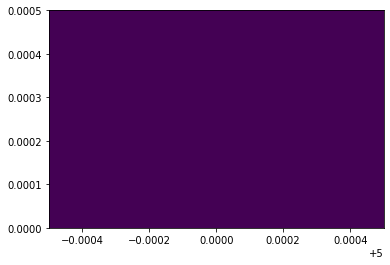

In [43]:
plt.pcolor(X,Y,C)
plt.show()